### Inserting token events

We would like to visualize how the model likelihoods look over real sequences

To do this nicely, we need to insert blank tokens in between the real observations (having children)

In [1]:
# change pwd to parent directory
import os

cwd = os.getcwd()
os.chdir(os.path.dirname(cwd))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
### Generate fake data 
from generate_fake_seq import create_fake_seq

n_individuals = int(10)  # Number of individuals
max_events_per_individual = 15 # Maximum number of events per individual
true_alpha, true_gamma, true_beta_c, true_delta_c, true_beta_s, true_delta_s = (
    -1,
    [0, 0],
    1, 10,
    1, 10
)

times, events, covariates, individuals = create_fake_seq(n_individuals, max_events_per_individual, true_alpha,
                            true_gamma, true_beta_c, true_delta_c, true_beta_s,
                            true_delta_s)

Proportion of nonzero events: 0.31645569620253167


In [4]:
obs_dict = {}

for i in np.unique(individuals):
    idx = individuals == i
    person_events = events[idx]
    obs_dict[i] = {
        'n_pos_events': np.sum(person_events == 1),
        'times': times[:, idx],
        'events': events[idx],
        'covariates': covariates[idx]
        }


In [21]:
# subselect the n individuals with the most positive events
n=3

obs_dict_filtered = {k: v for k, v in sorted(obs_dict.items(), key=lambda item: item[1]['n_pos_events'], reverse=True)[:n]}

In [22]:
def create_token_events(obs_dict_filtered, key, n_plot_events):
    pers_times = obs_dict_filtered[key]['times']
    pers_cont_time = pers_times[0]
    pers_disc_time = pers_times[1]

    pers_covariates = obs_dict_filtered[key]['covariates']

    token_cont_times = np.linspace(
        min(pers_cont_time),
        max(pers_cont_time),
        n_plot_events
        )

    # for each token time, find the index of the previous and subsequent continuous time
    prev_idx = np.searchsorted(pers_cont_time, token_cont_times, side='right') - 1

    token_discrete_times = pers_disc_time[prev_idx]
    token_covariates = pers_covariates[prev_idx]

    # initialize all tokens to zero
    token_events = np.zeros(n_plot_events)

    # set token_event with corresponding token_cont_time closest to pos event times to 1
    pers_events = obs_dict_filtered[key]['events']
    pos_events = pers_cont_time[pers_events == 1]
    pos_event_idx = np.searchsorted(token_cont_times, pos_events)
    token_events[pos_event_idx] = 1

    return token_cont_times, token_discrete_times, token_events, token_covariates


In [23]:
def create_token_times(obs_dict_filtered, n_plot_events):
    pers_times = obs_dict_filtered['times']
    pers_cont_time = pers_times[0]
    pers_disc_time = pers_times[1]

    token_cont_times = np.linspace(
        min(pers_cont_time),
        max(pers_cont_time),
        n_plot_events
        )

    prev_idx = np.searchsorted(pers_cont_time, token_cont_times, side='right') - 1

    token_discrete_times = pers_disc_time[prev_idx]

    return token_cont_times, token_discrete_times

# fit model and visualize model probabilities over token sequences

In [36]:
from src.self_exciting.hawkes_regression import SelfExcitingLogisticRegression as SELR
model = SELR(
    max_iter=int(10**4),
    time_types=['discrete', 'continuous'],
    ignore_errors=True,
    tol=1e-8
    )
model.fit(times_all=times, events_all=events, individuals_all=individuals, covariates_all=covariates)
model.beta_c = 10
model.delta_c = 10
model.beta_s = 10
model.delta_s = 1

[-0.43918248 -0.02961805  0.9614744   0.92331439  0.44957988  0.08245371
 -0.44621759]
Parameters: -2.7212119250610587, [-1.27030905  0.18816828], 8.491912797972587, 0.0001, 7.85787101068102, 0.0001
Number of parameters: 7


In [48]:
n_plot_events = 1000

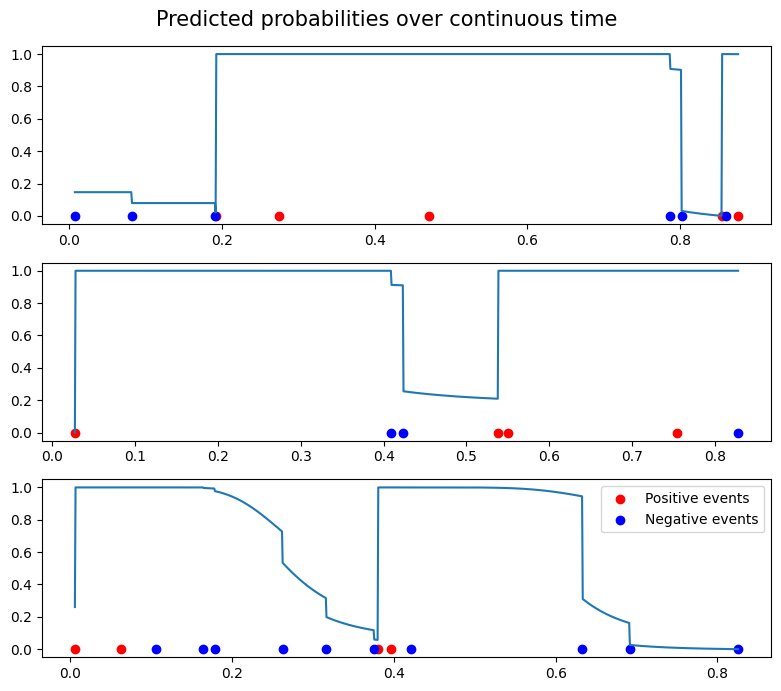

In [49]:
fig, ax = plt.subplots(figsize=(8,4 + int(n)), nrows=len(obs_dict_filtered), ncols=1)

for i, person_dict in enumerate(obs_dict_filtered.values()):
    token_cont_time, _ = create_token_times(person_dict, n_plot_events)

    person_probas = model.predict_probas(
                time_points=token_cont_time,
                event_times=person_dict['times'],
                covariates=person_dict['covariates'],
                events=person_dict['events']
    )
    
    # normalize
    person_probas = (person_probas - min(person_probas)) 
    person_probas = person_probas / max(person_probas)

    # plot the probas
    ax[i].plot(token_cont_time, person_probas)

    # plot the true events
    obs_events = person_dict['events']

    cont_times = person_dict['times'][0]
    pos_idx = obs_events == 1

    ax[i].scatter(cont_times[pos_idx], np.zeros(sum(pos_idx)), color='red', label='Positive events')
    ax[i].scatter(cont_times[~pos_idx], np.zeros(sum(~pos_idx)), color='blue', label='Negative events')

plt.legend()
plt.suptitle('Predicted probabilities over continuous time', fontsize=15)
plt.tight_layout()

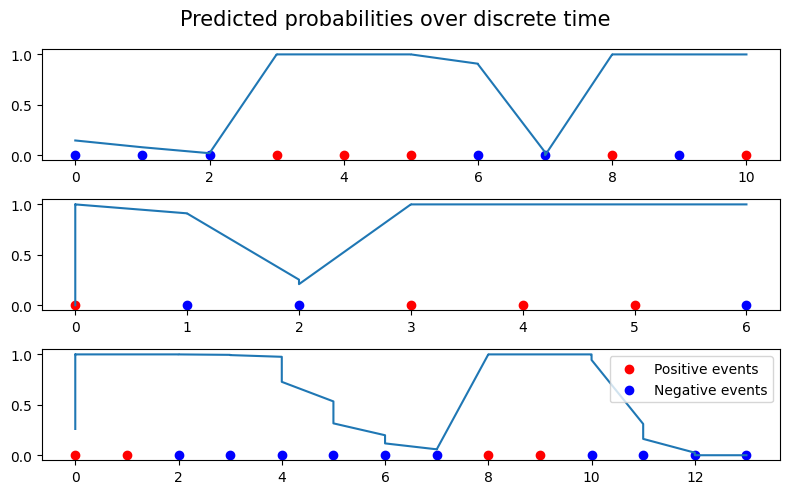

In [50]:
fig, ax = plt.subplots(figsize=(8,4 + int(n/2)), nrows=len(obs_dict_filtered), ncols=1)

for i, person_dict in enumerate(obs_dict_filtered.values()):
    token_cont_time, token_discrete_time = create_token_times(person_dict, n_plot_events)

    person_probas = model.predict_probas(
                time_points=token_cont_time,
                event_times=person_dict['times'],
                covariates=person_dict['covariates'],
                events=person_dict['events']
    )
    
    # normalize
    person_probas = (person_probas - min(person_probas)) 
    person_probas = person_probas / max(person_probas)

    # plot the probas
    ax[i].plot(token_discrete_time, person_probas)

    # plot the true events
    obs_events = person_dict['events']

    discrete_times = person_dict['times'][1]
    pos_idx = obs_events == 1

    ax[i].scatter(discrete_times[pos_idx], np.zeros(sum(pos_idx)), color='red', label='Positive events')
    ax[i].scatter(discrete_times[~pos_idx], np.zeros(sum(~pos_idx)), color='blue', label='Negative events')

plt.legend()
plt.suptitle('Predicted probabilities over discrete time', fontsize=15)
plt.tight_layout()


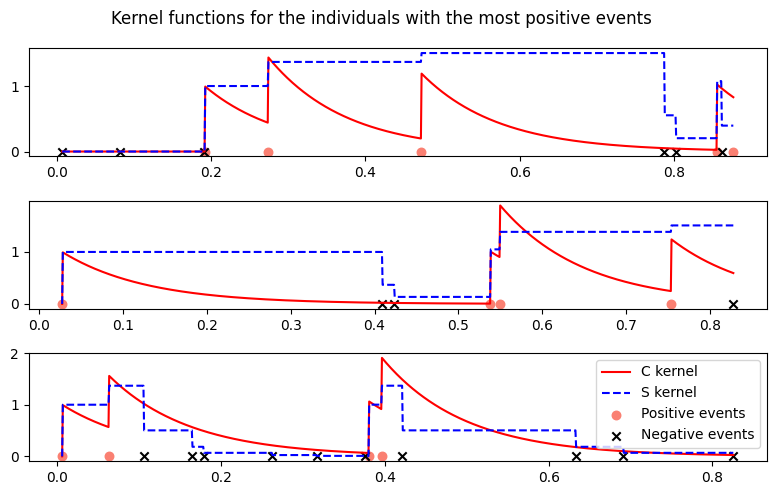

In [51]:
fig, ax = plt.subplots(figsize=(8,4 + int(n/2)), nrows=len(obs_dict_filtered), ncols=1)

for i, person_dict in enumerate(obs_dict_filtered.values()):
    token_cont_time, _ = create_token_times(person_dict, n_plot_events)

    _, c, s = model.predict_probas(
                time_points=token_cont_time,
                event_times=person_dict['times'],
                covariates=person_dict['covariates'],
                events=person_dict['events'],
                return_kernels=True
    )
    
    ax[i].plot(token_cont_time, c, 'r', label='C kernel')
    ax[i].plot(token_cont_time, s, 'b', label='S kernel', linestyle='dashed')

    # plot the true events
    obs_events = person_dict['events']
    cont_times = person_dict['times'][0]
    pos_idx = obs_events == 1

    ax[i].scatter(cont_times[pos_idx], np.zeros(sum(pos_idx)), color='salmon', label='Positive events', marker='.', s=150)
    ax[i].scatter(cont_times[~pos_idx], np.zeros(sum(~pos_idx)), color='black', label='Negative events', marker='x')

plt.legend()
plt.suptitle('Kernel functions for the individuals with the most positive events')
plt.tight_layout()

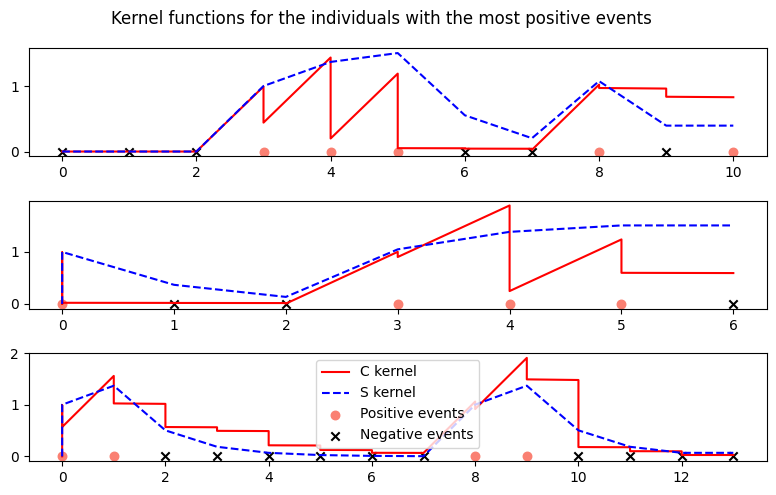

In [52]:
fig, ax = plt.subplots(figsize=(8,4 + int(n/2)), nrows=len(obs_dict_filtered), ncols=1)

for i, person_dict in enumerate(obs_dict_filtered.values()):
    token_cont_time, token_discrete_time = create_token_times(person_dict, n_plot_events)

    _, c, s = model.predict_probas(
                time_points=token_cont_time,
                event_times=person_dict['times'],
                covariates=person_dict['covariates'],
                events=person_dict['events'],
                return_kernels=True
    )
    
    ax[i].plot(token_discrete_time, c, 'r', label='C kernel')
    ax[i].plot(token_discrete_time, s, 'b', label='S kernel', linestyle='dashed')

    # plot the true events
    obs_events = person_dict['events']
    discrete_times= person_dict['times'][1]
    pos_idx = obs_events == 1

    ax[i].scatter(discrete_times[pos_idx], np.zeros(sum(pos_idx)), color='salmon', label='Positive events', marker='.', s=150)
    ax[i].scatter(discrete_times[~pos_idx], np.zeros(sum(~pos_idx)), color='black', label='Negative events', marker='x')

plt.legend()
plt.suptitle('Kernel functions for the individuals with the most positive events')
plt.tight_layout()